In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
training_file = "/content/drive/MyDrive/test.p"
testing_file = "/content/drive/MyDrive/mc/train.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [5]:
sign_name_df = pd.read_csv('/content/drive/MyDrive/signname.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [6]:
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
# Define features and labels for training data
X, y = train['features'], train['labels']

# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']

# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)
(34799, 32, 32, 3) (34799,)


In [8]:
X, y = train['features'], train['labels']

In [9]:
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

(12630, 32, 32, 3) (12630,)


In [10]:
X_test, y_test = test['features'], test['labels']

In [11]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(11367, 32, 32, 3) (1263, 32, 32, 3) (11367,) (1263,)


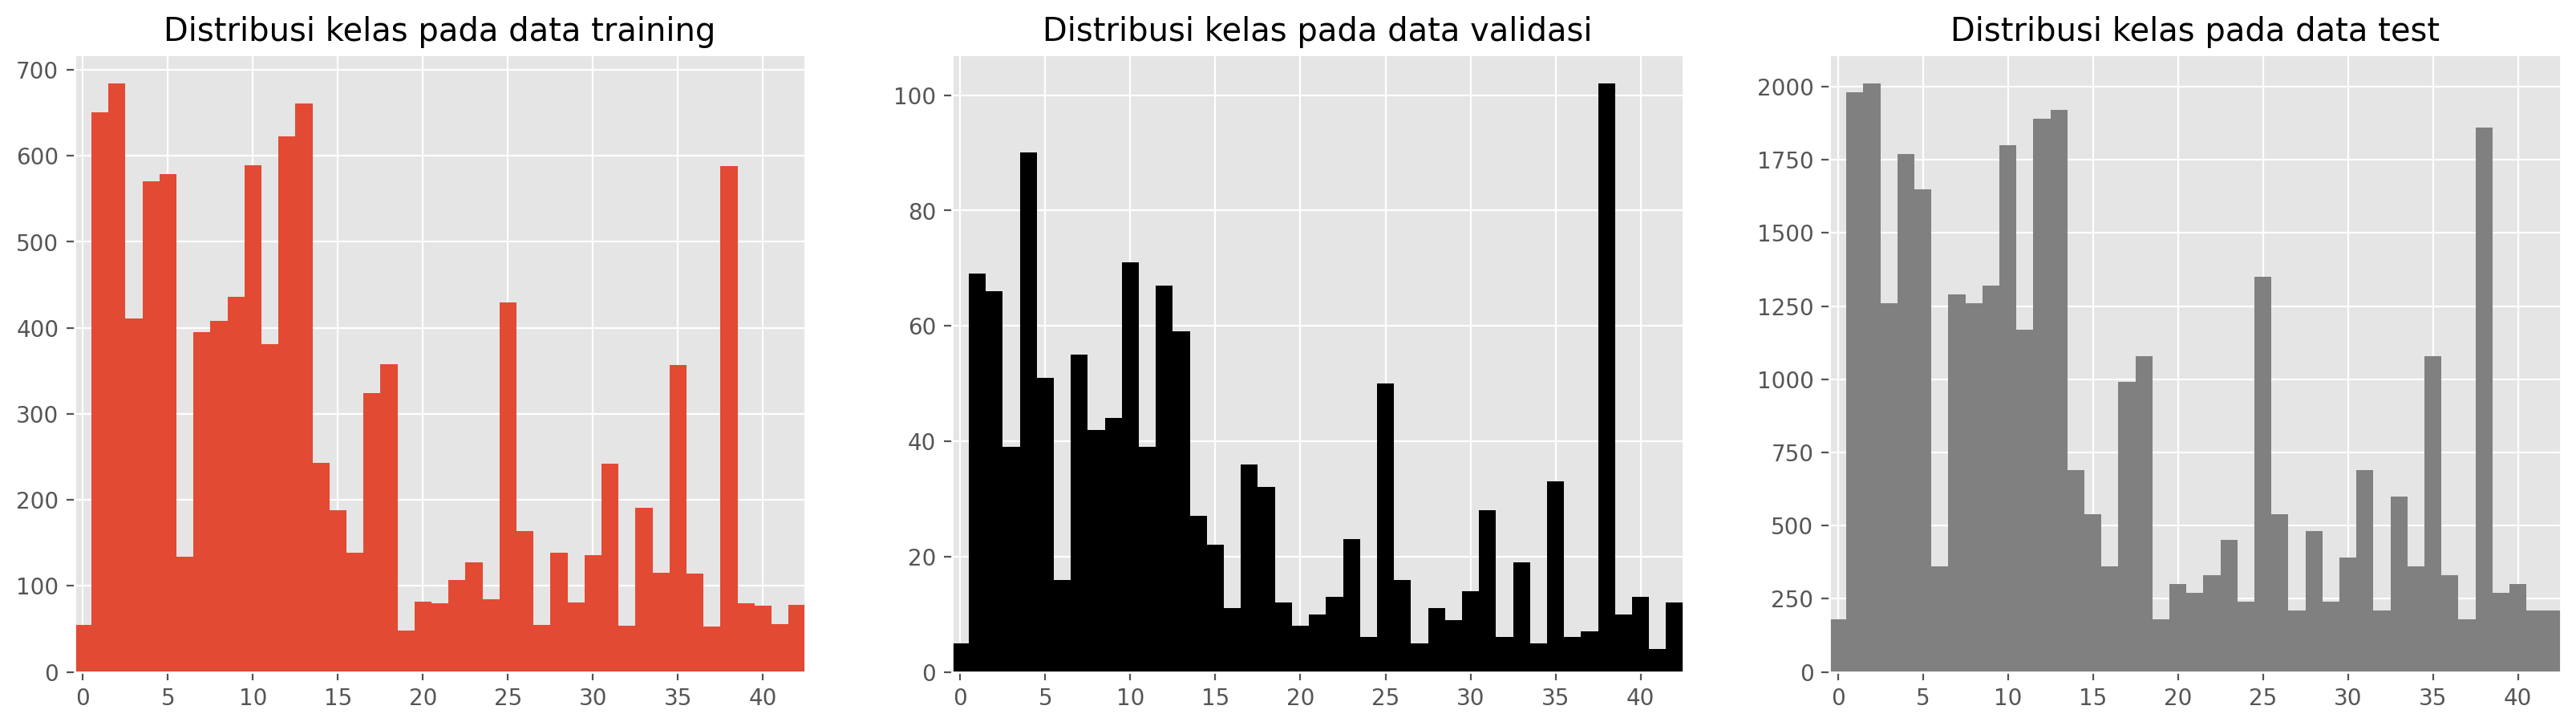

In [13]:
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

In [16]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
356/356 [==============================] - 61s 168ms/step - loss: 2.9481 - accuracy: 0.2856 - val_loss: 1.3615 - val_accuracy: 0.6390
Epoch 2/25
356/356 [==============================] - 54s 151ms/step - loss: 1.2403 - accuracy: 0.6470 - val_loss: 0.6800 - val_accuracy: 0.8179
Epoch 3/25
356/356 [==============================] - 54s 152ms/step - loss: 0.7691 - accuracy: 0.7797 - val_loss: 0.2904 - val_accuracy: 0.9398
Epoch 4/25
356/356 [==============================] - 56s 156ms/step - loss: 0.5772 - accuracy: 0.8330 - val_loss: 0.1961 - val_accuracy: 0.9557
Epoch 5/25
356/356 [==============================] - 69s 194ms/step - loss: 0.4642 - accuracy: 0.8665 - val_loss: 0.1693 - val_accuracy: 0.9691
Epoch 6/25
356/356 [==============================] - 59s 166ms/step - loss: 0.3858 - accuracy: 0.8851 - val_loss: 0.1459 - val_accuracy: 0.9770
Epoch 7/25
356/356 [==============================] - 68s 190ms/step - loss: 0.3277 - accuracy: 0.9016 - val_loss: 0.0943 - val_ac

In [20]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


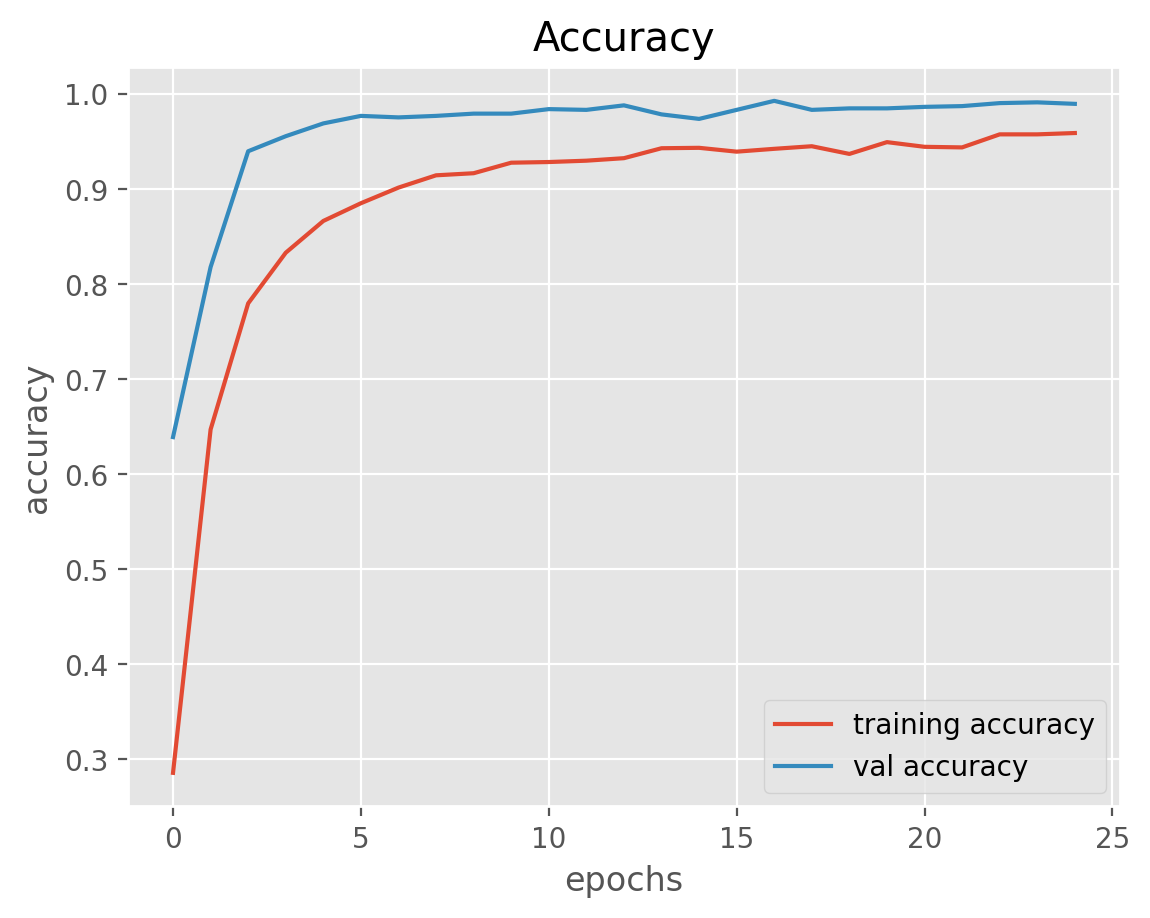

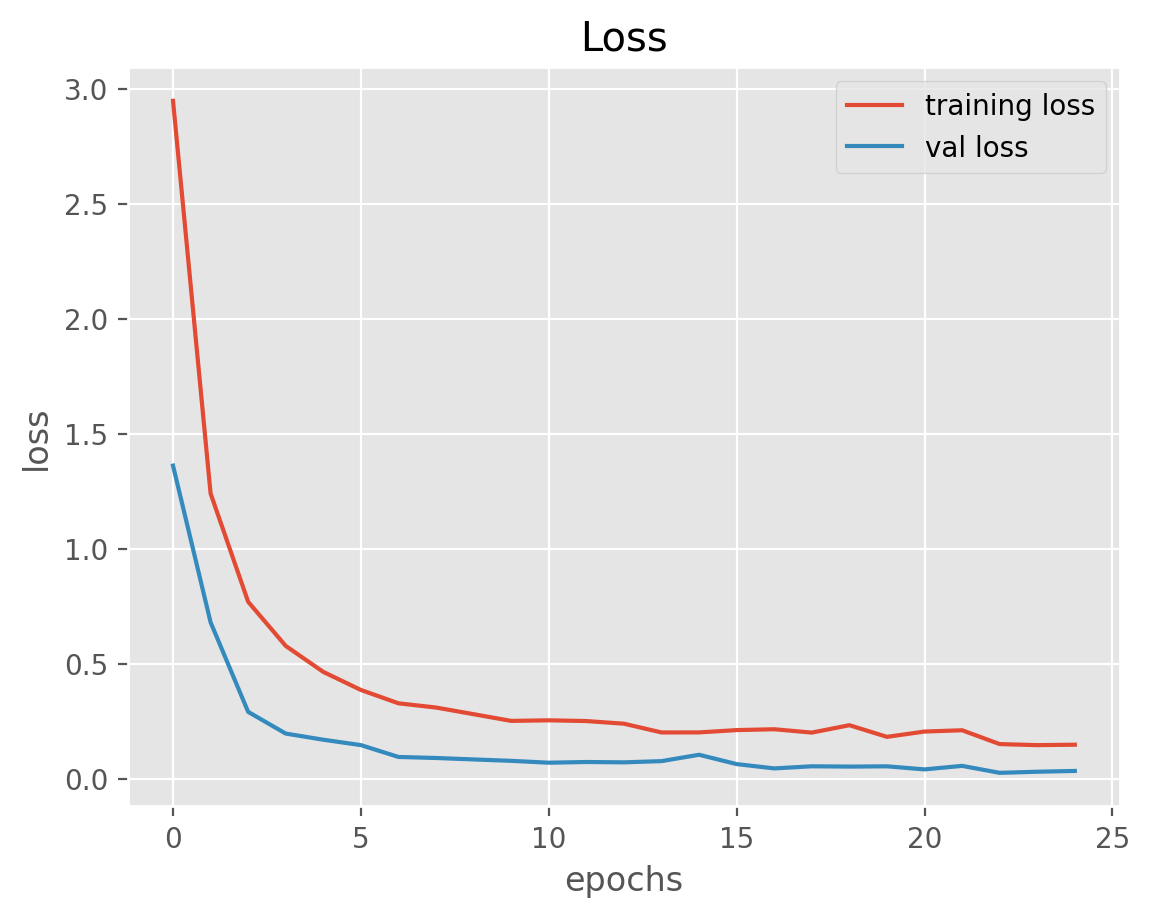

In [21]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

1088/1088 [==============================] - 44s 41ms/step


0.9081295439524124

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       180
           1       0.91      0.91      0.91      1980
           2       0.96      0.93      0.95      2010
           3       0.96      0.88      0.92      1260
           4       0.93      0.93      0.93      1770
           5       0.87      0.90      0.88      1650
           6       0.96      0.97      0.96       360
           7       0.85      0.96      0.90      1290
           8       0.89      0.94      0.91      1260
           9       0.95      0.97      0.96      1320
          10       0.93      1.00      0.96      1800
          11       0.91      0.86      0.88      1170
          12       0.95      0.97      0.96      1890
          13       0.99      0.96      0.98      1920
          14       0.91      0.99      0.95       690
          15       0.98      0.91      0.94       540
          16       0.99      0.89      0.94       360
          17       0.99    